
# Классификация изображений


In [ ]:
!nvidia-smi

In [8]:
!pip install git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-84hfyrhq
     |████████████████████████████████| 50 kB 824 kB/s eta 0:00:011
  Created wheel for efficientnet: filename=efficientnet-1.1.1-py3-none-any.whl size=18420 sha256=dcf056cee400a1274301a95bae44cb2155d39e9012920471066de844ec6183fb
  Stored in directory: /tmp/pip-ephem-wheel-cache-hgbbpgds/wheels/11/69/85/814d64d694c96db0eef17b718042d644a1e54f113920481920
Successfully built efficientnet
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os


import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import *

import efficientnet.tfkeras as efn

from sklearn.model_selection import train_test_split, StratifiedKFold

from tqdm import tqdm

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

In [ ]:
!pip freeze > requirements.txt

# Основные настройки

In [17]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

EPOCHS               = 5  # эпох на обучение
BATCH_SIZE           = 6 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 400 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '../input/'
PATH = "../working/car/" # рабочая директория

In [20]:
# Устаналиваем конкретное значение random seed для воспроизводимости
os.makedirs(PATH,exist_ok=False)

RANDOM_SEED = 33
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# EDA / Анализ данных

In [21]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [ ]:
train_df.info()

In [ ]:
train_df.Category.value_counts()
# распределение классов достаточно равномерное - это хорошо

In [22]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile("../input/"+data_zip,"r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем картинки
['train', 'test_upload']


Пример картинок (random sample)


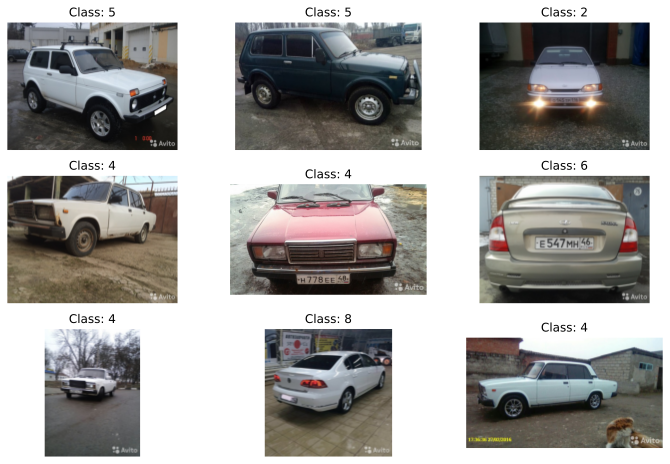

In [23]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Посмотрим на примеры картинок и их размеры чтоб понимать как их лучше обработать и сжимать.

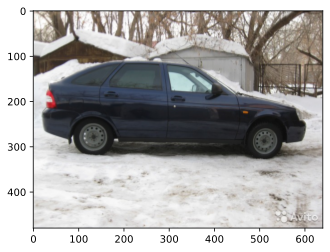

(640, 480)

In [24]:
image = PIL.Image.open(PATH+'/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

# Подготовка данных

### Аугментация данных

In [25]:
# Вы помните, что аугментация данных важна, когда мы работаем с небольшим датасетом. Это как раз наш случай.
# Чтобы лучше понять работу параметров, попробуйте их изменить. К какому результату это приведет?
# Официальная документация: https://keras.io/preprocessing/image/

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=False)

test_datagen = ImageDataGenerator(rescale=1. / 255)

#Рекомендация Подключите более продвинутые библиотеки аугментации изображений (например: albumentations или imgaug, для них есть специальные "обертки" под Keras, например: https://github.com/mjkvaak/ImageDataAugmentor)

### Генерация данных

In [26]:
# Завернем наши данные в генератор:

train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

# Обратите внимание, что для сабмита мы используем другой источник test_datagen.flow_from_dataframe. Как вы думаете, почему?

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


# Построение модели

### Загружаем предобученную сеть EfficientNetB6:

In [27]:
base_model = efn.EfficientNetB6(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, IMG_CHANNELS))

165527552/165527152 [==============================] - 2s 0us/step


In [28]:
"""
model=M.Sequential()
model.add(base_model)
model.add(L.GlobalAveragePooling2D(),)
model.add(L.Dense(256, activation='elu'))
model.add(L.BatchNormalization())
model.add(L.Dropout(0.25))
model.add(L.Dense(128, activation='elu'))
model.add(L.BatchNormalization())
model.add(L.Dropout(0.25))
model.add(L.Dense(10, activation='softmax'))
"""



x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='elu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(128, activation='elu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
predictions = Dense(10, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=predictions)

In [29]:
tf.keras.backend.clear_session()

LR=0.0001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [30]:
checkpoint = ModelCheckpoint('best_model.hdf5' , 
                             monitor = ['val_accuracy'] , 
                             verbose = 1, 
                             mode = 'max')
callbacks_list = [checkpoint]

In [31]:
history = model.fit(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//test_generator.batch_size,
        epochs = 7,
        callbacks = callbacks_list
)

Epoch 1/7
2205/2205 [==============================] - ETA: 0s - loss: 0.9571 - accuracy: 0.6815
Epoch 00001: saving model to best_model.hdf5
2205/2205 [==============================] - 1450s 658ms/step - loss: 0.9571 - accuracy: 0.6815 - val_loss: 0.1519 - val_accuracy: 0.9467
Epoch 2/7
2205/2205 [==============================] - ETA: 0s - loss: 0.3756 - accuracy: 0.8817
Epoch 00002: saving model to best_model.hdf5
2205/2205 [==============================] - 1449s 657ms/step - loss: 0.3756 - accuracy: 0.8817 - val_loss: 0.1224 - val_accuracy: 0.9639
Epoch 3/7
2205/2205 [==============================] - ETA: 0s - loss: 0.2854 - accuracy: 0.9108
Epoch 00003: saving model to best_model.hdf5
2205/2205 [==============================] - 1457s 661ms/step - loss: 0.2854 - accuracy: 0.9108 - val_loss: 0.1118 - val_accuracy: 0.9661
Epoch 4/7
2205/2205 [==============================] - ETA: 0s - loss: 0.2310 - accuracy: 0.9258
Epoch 00004: saving model to best_model.hdf5
2205/2205 [=======

In [32]:
scores = model.evaluate(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

389/389 [==============================] - 115s 296ms/step - loss: 0.1073 - accuracy: 0.9687
Accuracy: 96.87%


In [2]:
test_sub_generator.reset()
predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

NameError: name 'test_sub_generator' is not defined

In [3]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission7.csv', index=False)
print('Save submit')

NameError: name 'test_sub_generator' is not defined

Чем больше эпох на этой сетке тем лучше результат, но это ппц как долго по времени

In [19]:
# Clean PATH
import shutil
shutil.rmtree(PATH)